# Test Notebook to test the BERT MLP

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from fetchData import fetchdata 

In [45]:
pheme_w2v = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_sparse = pd.read_csv('./data/_PHEME_sparse.csv')
pheme_event = pd.read_csv('./data/_PHEME_text.csv').Event

ext_w2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_sparse = pd.read_csv('./data/_PHEMEext_sparse.csv')
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')

pheme_bert = fetchdata('pheme','bert')
ext_bert = fetchdata('ext','bert')
rhi_bert = fetchdata('rhi','bert')

In [46]:
pd.read_csv('./data/_PHEMEext_text.csv')

,text,Event,target
0,Micheal Essien denying the Ebola rumours like ...,ebola-essien,1
1,No truth in internet rumours that I have contr...,ebola-essien,1
2,Essien and his lawyers are considering to file...,ebola-essien,1
3,Good news: The rumours that Michael Essien has...,ebola-essien,1
4,Milan have stated that the reports about Essie...,ebola-essien,1
...,...,...,...
480,Ex-KGB Yuri Shvets at #Litvinenko inquiry-#Put...,putinmissing,0
481,"Death came for Pratchett, picked up Putin for ...",putinmissing,0
482,the plot thickens - #putindead http://t.co/Vie...,putinmissing,0
483,Putin juggling enough instability. He would ma...,putinmissing,0


In [47]:
pheme_sparse.verified = pheme_sparse.verified.replace({True: 1, False: 0}) 
ext_sparse.verified = ext_sparse.verified.replace({True: 1, False: 0}) 
pheme_sparse.has_question = pheme_sparse.has_question.replace({True: 1, False: 0}) 
ext_sparse.has_question = ext_sparse.has_question.replace({True: 1, False: 0}) 
pheme_sparse.has_exclaim = pheme_sparse.has_exclaim.replace({True: 1, False: 0}) 
ext_sparse.has_exclaim = ext_sparse.has_exclaim.replace({True: 1, False: 0}) 
pheme_sparse.has_period = pheme_sparse.has_period.replace({True: 1, False: 0}) 
ext_sparse.has_period = ext_sparse.has_period.replace({True: 1, False: 0}) 

In [48]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [49]:
tensor_x1 = torch.Tensor(pheme_bert.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(ext_bert.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [50]:
# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

task1_train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=2)
task1_test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print(tensor_x1.shape)
print(tensor_y1.shape)
print(train_size)
print(test_size)


torch.Size([5802, 1, 768])
torch.Size([5802, 1])
5802
485


In [51]:
class BERT_net(nn.Module):
    def __init__(self):
        super(BERT_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(768, 50, bias=True) # 420
        self.fc2 = nn.Linear(50, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [53]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

model = BERT_net()
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

prev_loss = 10
PATH = "./state_dict_task1_model.pt"
best_acc = 10.0
num_epochs = 10

In [54]:
val_corrects_list = []
val_loss_list = []
for epoch in range(num_epochs):  # loop over the dataset multiple times
    # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    # print('-' * 10)
    running_corrects = 0.0
    running_loss = 0.0
    model.train()  # Set model to training mode
    for i, data in enumerate(task1_train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.float(), labels.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # print(preds)

        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        # step function
        scheduler.step() 

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)
    if (epoch%2==0):
        print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch, num_epochs - 1,epoch_acc, epoch_loss))

    # Evaluation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        val_preds_list = []
        val_label_list = []
        for j, val in enumerate(task1_test_dataloader, 0):
            val_x, val_label = val
            val_x, val_label = val_x.float(), val_label.float()
            val_outputs = model(val_x)
            _, val_preds = torch.max(val_outputs, 1)

            val_preds_list.append(val_preds.data)
            val_label_list.append(val_label.data)
            v_loss = criterion(val_outputs, val_label.unsqueeze(1))
            val_loss += (v_loss.item() * val_x.size(0))
            val_corrects += torch.sum(val_preds == val_label.data).double()
        if (epoch%2==0):
            val_preds_list = torch.cat(val_preds_list, 0)
            val_label_list = torch.cat(val_label_list, 0)
            print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(val_corrects/test_size,val_loss/test_size))
            # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size,val_loss/test_size,f1_score(val_label_list,val_preds_list,average='macro')))
        val_corrects_list.append(val_corrects/test_size)
        val_loss_list.append(val_loss/test_size)

    if epoch_loss < best_acc:
        # print("prev_loss: {:.5f}".format(prev_loss))
        # print("loss: {:.5f}".format(loss))
        print("Saving the best model w/ loss {:.4f}".format(epoch_loss))
        torch.save(model.state_dict(),PATH)
        best_acc = epoch_loss

Epoch 0/9	Train) Acc: 0.5074, Loss: 0.5441
		Validation) Acc: 0.2392 Loss:1.0305
Saving the best model w/ loss 0.5441
Saving the best model w/ loss 0.4984
Epoch 2/9	Train) Acc: 0.4874, Loss: 0.4708
		Validation) Acc: 0.2392 Loss:0.9569
Saving the best model w/ loss 0.4708
Saving the best model w/ loss 0.4663
Epoch 4/9	Train) Acc: 0.5024, Loss: 0.4821
		Validation) Acc: 0.2392 Loss:0.9749
Epoch 6/9	Train) Acc: 0.5005, Loss: 0.4727
		Validation) Acc: 0.2392 Loss:0.9749
Epoch 8/9	Train) Acc: 0.5110, Loss: 0.4836
		Validation) Acc: 0.2392 Loss:0.9749


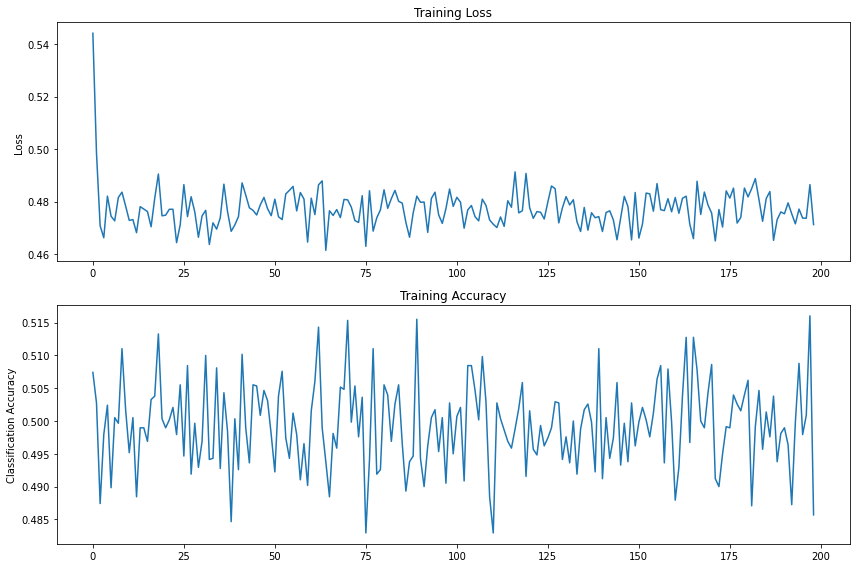

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss[:])
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy[:])
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

In [37]:
count =0
for j, val in enumerate(task1_test_dataloader, 0):
    x, y = val
    # print(x.size())
    print(x.size(0))

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
5


In [39]:
ext_y

0      1
1      1
2      1
3      1
4      1
      ..
480    0
481    0
482    0
483    0
484    0
Name: target, Length: 485, dtype: int64